Utilisation des fichiers initiaux pour la prédiction  
[ARIMA](#ARIMA)  
[XGBoost](#XGBoost)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

from statsmodels.api import datasets

import pmdarima as pm

# Read file

In [2]:
df0 = pd.read_csv("climate/DailyDelhiClimateTrain.csv")
target = 'meantemp'
endog_names = [target]
exog_names = ["humidity", "wind_speed", "meanpressure"]

# df0 = datasets.nile.load_pandas().data
# target = "volume"
# endog_names = [target]
# exog_names = []

n_endog = len(endog_names)  # must be equal to 1 to use ARIMA
n_exog = len(exog_names)

df_exogeneous = df0[exog_names]  
df_endogeneous = df0[endog_names]
df = pd.concat([df_endogeneous, df_exogeneous], axis=1)

n = df.shape[0]
n

1462

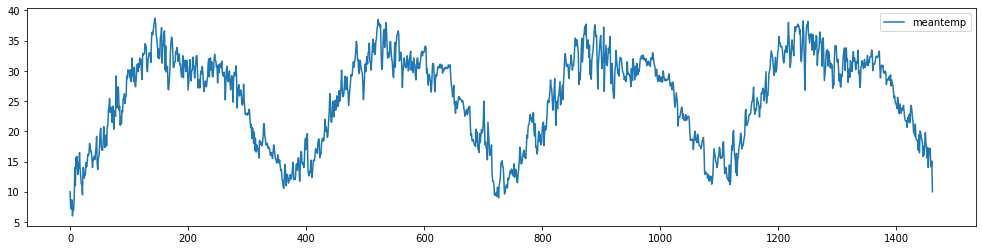

In [3]:
# Plot des variables endogènes
df[endog_names].plot(subplots=True, figsize=(17,4*n_endog));

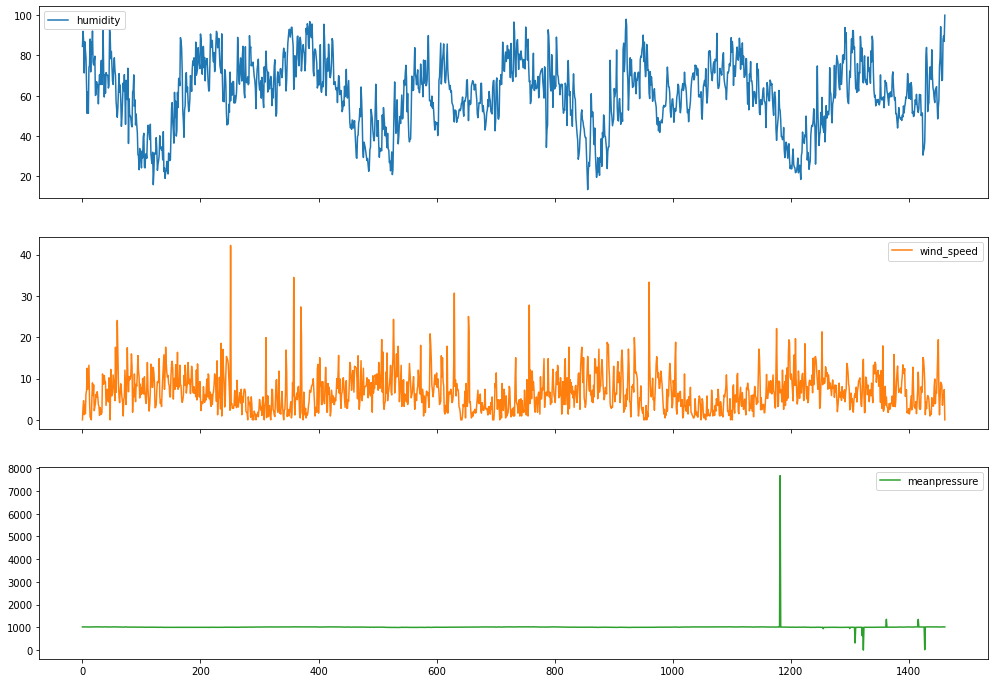

In [4]:
# Plot des variables exogènes
df[exog_names].plot(subplots=True, figsize=(17,4*n_exog));

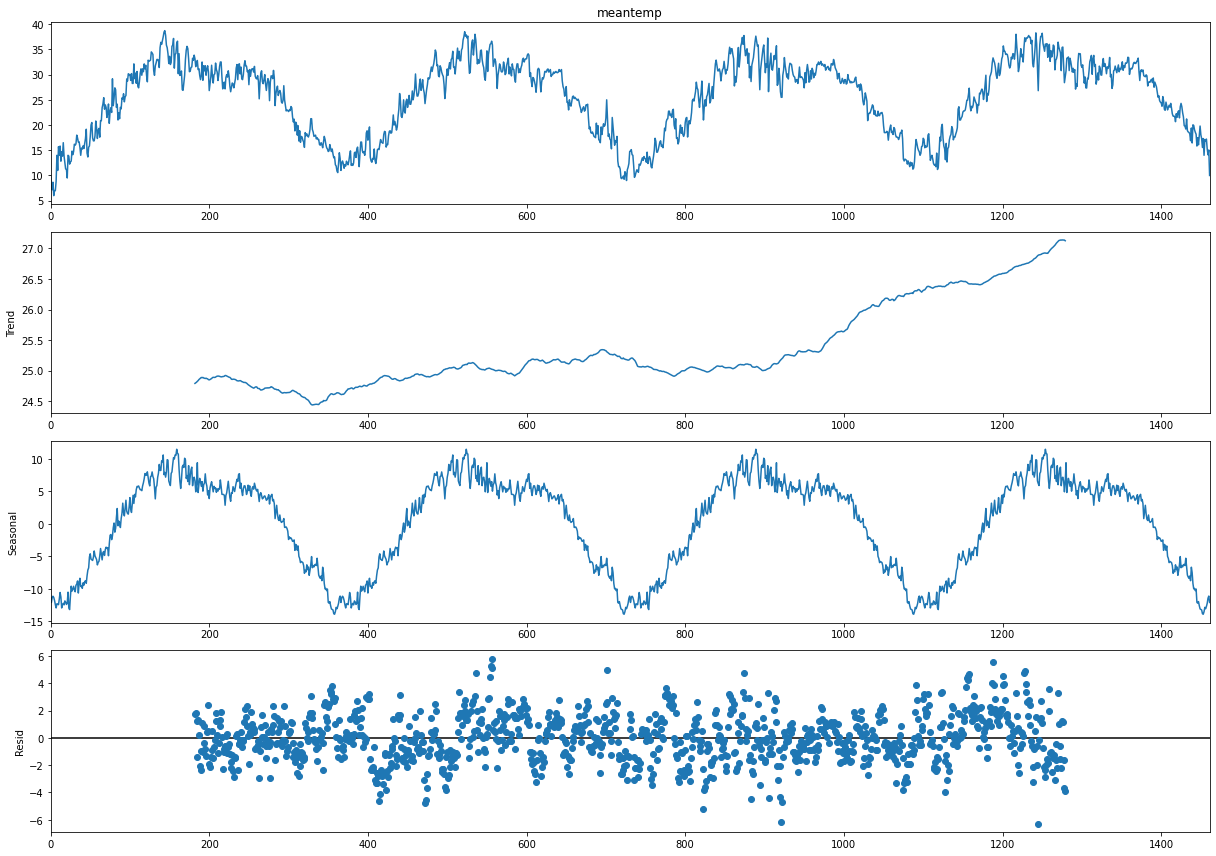

In [5]:
# Décomposition de la time series
plt.rcParams["figure.figsize"] = (17,12)
sd = seasonal_decompose(df[target], period=365, model='add')
sd.plot();

mean: 1.586e-02
std: 1.775e+00


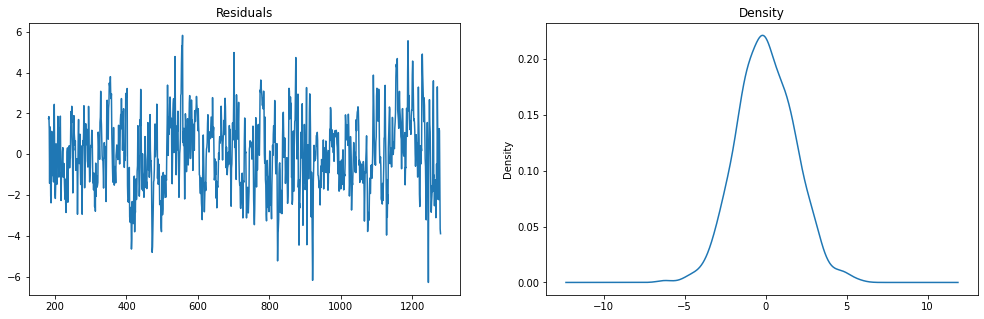

In [6]:
residuals = pd.DataFrame(sd.resid).dropna()
fig, axs = plt.subplots(1,2, figsize=(17,5))
print(f"mean: {residuals.mean()[0]:0.3e}")
print(f"std: {residuals.std()[0]:0.3e}")
residuals.plot(title="Residuals", legend=False, ax=axs[0])
residuals.plot(kind='kde', title='Density', legend=False, ax=axs[1]);

Find `(p,d,q)` coefficients

# Split data (train, test)

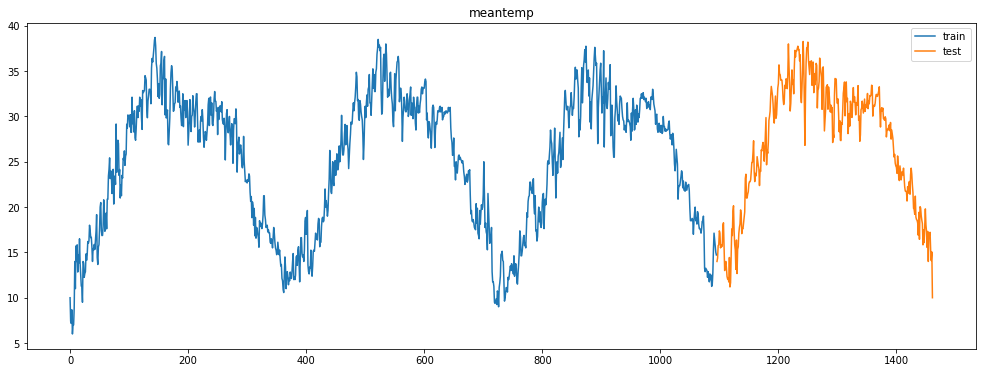

In [7]:
per_test = 0.25
per_train = 1 - per_test

y_train, y_test = train_test_split(df, test_size=per_test, shuffle=False)

y_train_endog, y_test_endog = y_train[endog_names], y_test[endog_names]
y_train_exog, y_test_exog = y_train[exog_names], y_test[exog_names]

pd.concat([y_train_endog, y_test_endog], axis=1)[target].plot(figsize=(17,6))
plt.title(target)
plt.legend(['train', 'test']);

# ARIMA
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA

Apply ARIMA model on data  

`p` coef in **AR** term

* Keep the most significant lags (above the significance line)

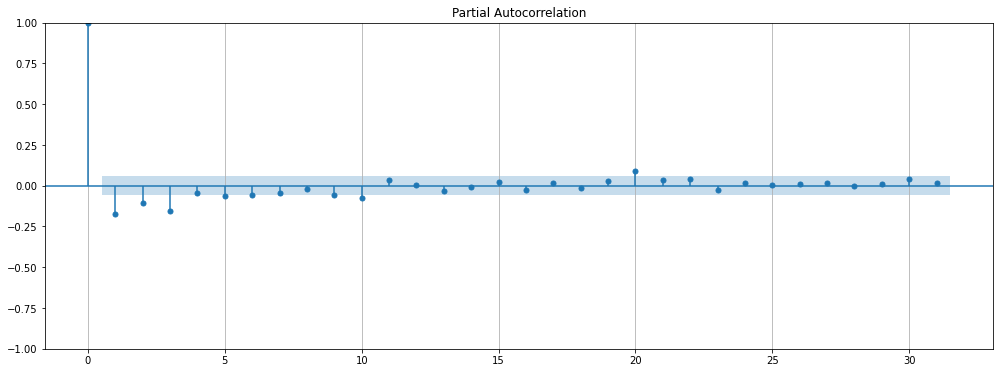

In [8]:
fig, ax = plt.subplots(1, figsize=(17,6))
ax.grid(axis='x')
ax.set_xticks(np.arange(0, 51, 5))
plot_pacf(y_train_endog.diff().dropna(), method='ywm', ax=ax);

`d` coef in **I** term

* Differenciate the series until stationarity
* Augmented Dickey-Fuller test tests non-stationarity of the series  
$H_0$: non stationary serie  
$H_1$: stationary serie

p-value: 3.976e-23


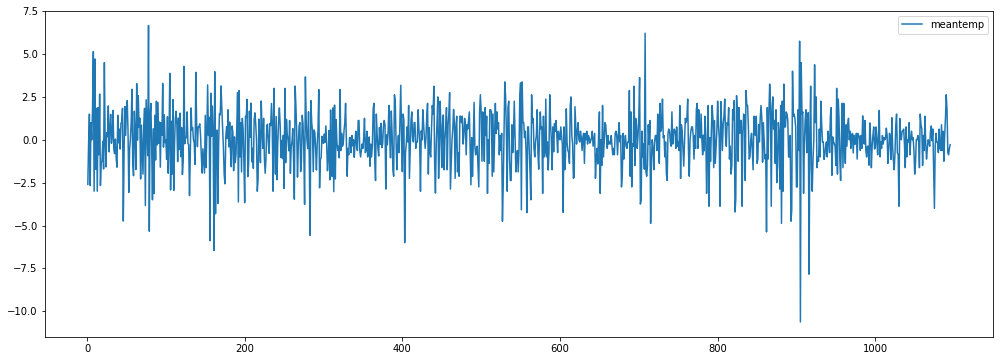

In [9]:
serie = y_train_endog.diff().dropna()
print(f"p-value: {adfuller(serie)[1]:.3e}")
serie.plot(figsize=(17,6));

`q` coef in **MA** term

* Keep the most significant lags (above the significance line)

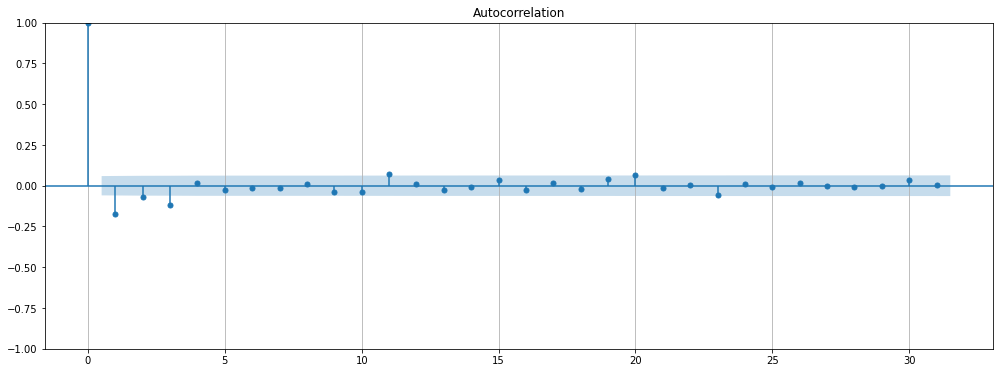

In [10]:
fig, ax = plt.subplots(1, figsize=(17,6))
ax.grid(axis='x')
ax.set_xticks(np.arange(0, 51, 5))
plot_acf(y_train_endog.diff().dropna(), ax=ax);

### Find ARIMA coefficients  automatically

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [11]:
model = pm.auto_arima(y_train_endog, 
                      #X=y_train_exog,
                      test='adf',           # use adftest to find optimal 'd'
                      start_p=0,
                      d=None,               # let model determine 'd'
                      start_q=0,
                      max_p=3,
                      max_q=3,
                      m=1,                  # frequency of series
                      seasonal=False,       # seasonality
                      start_P=0, 
                      D=None,
                      start_Q=0,
                      max_P=0,
                      max_Q=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4240.311, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4209.863, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4199.830, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4238.319, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4163.541, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4165.540, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4165.540, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4182.215, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4200.106, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4165.445, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4161.587, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4197.847, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4207.875, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4163.586, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2077.793
Date:                Wed, 25 May 2022   AIC                           4161.587
Time:                        17:10:39   BIC                           4176.582
Sample:                             0   HQIC                          4167.261
                               - 1096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5663      0.054     10.541      0.000       0.461       0.672
ma.L1         -0.7943      0.043    -18.445      0.000      -0.879      -0.710
sigma2         2.6039      0.081     32.097      0.000       2.445       2.763
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               256.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.48
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit ARIMAX

In [12]:
model = ARIMA(endog=y_train_endog, 
              exog=y_train_exog,
              order=(1,0,3))

model_arima = model.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1096
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1936.628
Date:                Wed, 25 May 2022   AIC                           3891.255
Time:                        17:10:40   BIC                           3936.250
Sample:                             0   HQIC                          3908.280
                               - 1096                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          806.3681     21.198     38.039      0.000     764.820     847.916
humidity        -0.1162      0.005    -25.516      0.000      -0.125      -0.107
wind_speed      -0.0212      0.008     -2.568      0.010      -0.037      -0.005
meanpressure    -0.7678      0.021    -36.562      0.000      -0.809      -0.727
ar.L1            0.9169      0.019     48.722      0.000       0.880       0.954
ma.L1           -0.0051      0.034     -0.152      0.879      -0.071       0.061
ma.L2           -0.2269      0.036     -6.289      0.000      -0.298      -0.156
ma.L3           -0.1328      0.032     -4.135      0.000      -0.196      -0.070
sigma2           1.9977      0.081     24.750      0.000       1.840       2.156
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               164.03
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.33
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

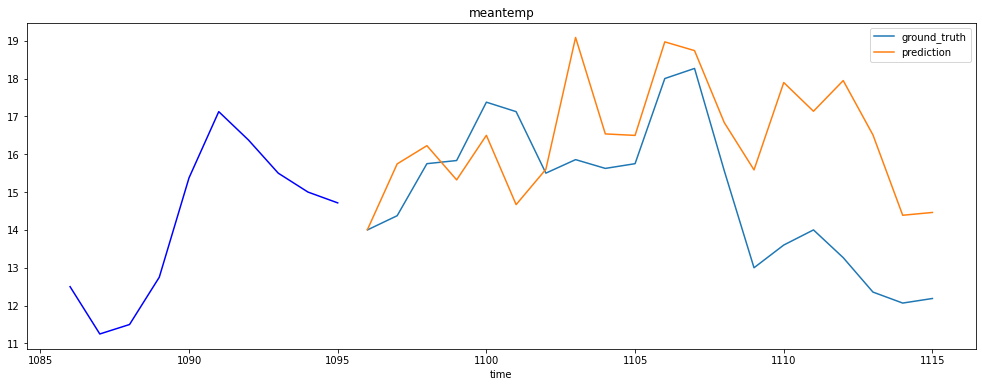

In [13]:
n0 = int(n*per_train)
step = 20
end = n0 + step
predictions = model_arima.predict(start=n0, end=end,
                                  exog=y_test_exog.iloc[:end-n0+1],
                                  dynamic=False)
predictions.index = predictions.index - predictions.index.min() + y_test_endog.index.min()

fig, ax = plt.subplots(1,1, figsize=(17,6))
y_test_endog.iloc[:end-n0].plot(ax=ax)
predictions.iloc[:end-n0].plot(ax=ax)
y_train_endog.iloc[-10:].plot(ax=ax, color='b')
plt.xlabel("time")
plt.title(target)
plt.legend(["ground_truth", "prediction"]);

In [14]:
def plot_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"correlation: {np.corrcoef(y_true, y_pred)[0,1]:.3f}")
    print(f"mape: {mape:.2e}")
    print(f"mse: {mse:.2e}")
    print(f"mae: {mae:.2e}")
    print(f"r2: {r2}")
    print(f"\nRMSE is {np.sqrt(mse)/y_true.mean()*100:0.2f}% of the mean")
    
plot_metrics(df_endogeneous[[target]].iloc[n0:end+1].squeeze(), predictions)

correlation: 0.494
mape: 1.34e-01
mse: 5.39e+00
mae: 1.86e+00
r2: -0.44768556525718317

RMSE is 15.67% of the mean


meantemp       mean   mean_se  mean_ci_lower  mean_ci_upper
1096      14.007069  1.413404      11.236848      16.777290
1097      15.744405  1.912747      11.995490      19.493321
1098      16.225768  2.097621      12.114507      20.337029
1099      15.322057  2.182234      11.044957      19.599158
1100      16.499224  2.250913      12.087516      20.910933


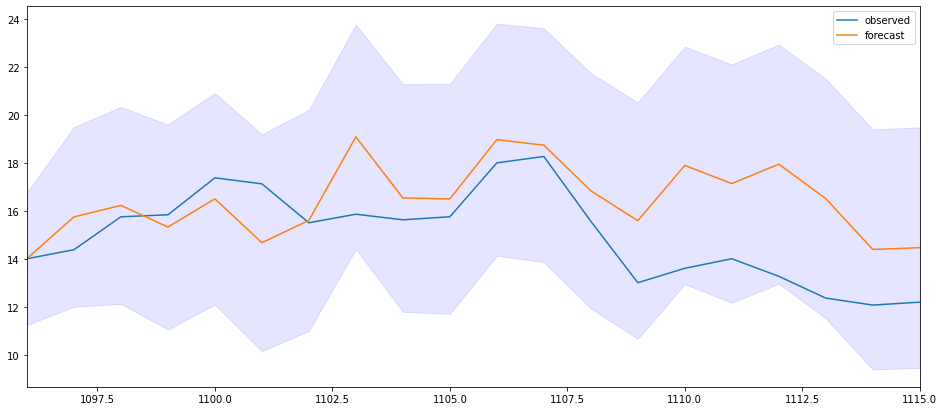

In [15]:
res = model_arima.get_forecast(step,
                               exog=y_test_exog.iloc[:end-n0]
                              ).summary_frame(alpha=0.05)
print(res.head())

y_test_endog[:end-n0].plot(legend=True, figsize=(16,7))
plt.plot(res["mean"])
plt.autoscale(axis='x',tight=True)
plt.fill_between(res["mean"].index, res["mean_ci_lower"], res["mean_ci_upper"], color='b', alpha=.1)
plt.legend(['observed', 'forecast']);

# XGBoost

In [16]:
from xgboost import XGBRegressor

## Preprocessing

#### Lag differencing

Can be use to remove seasonality if `lag` period is **T**

`lag` can be set to :
* 12 for monthly data
* ...

In [17]:
lag = 1
# df[target] = df[target].diff(lag)
# df = df.dropna(inplace=False)
# df[target]

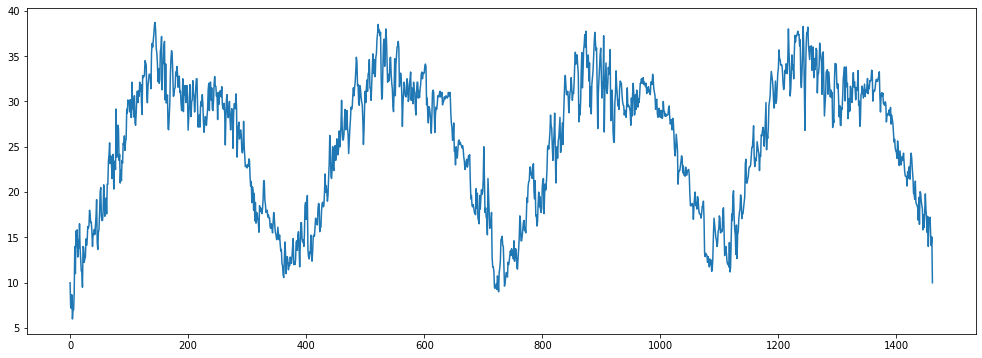

In [18]:
plt.figure(figsize=(17,6))
plt.plot(df[target]);

### Prepare data

#### Scale data

In [19]:
scaler_endog = [StandardScaler(), MinMaxScaler()][1]
y_train_endog_scaled = pd.DataFrame(scaler_endog.fit_transform(y_train_endog), columns=endog_names)
y_test_endog_scaled = pd.DataFrame(scaler_endog.transform(y_test_endog), columns=endog_names)

y_train_exog_scaled = pd.DataFrame()
y_test_exog_scaled = pd.DataFrame()
if exog_names:
    scaler_exog = [StandardScaler(), MinMaxScaler()][1]
    y_train_exog_scaled = pd.DataFrame(scaler_exog.fit_transform(y_train_exog), columns=exog_names)
    y_test_exog_scaled = pd.DataFrame(scaler_exog.transform(y_test_exog), columns=exog_names)

y_train_scaled = pd.concat([y_train_endog_scaled, y_train_exog_scaled], axis=1).set_index(y_train.index)
y_test_scaled = pd.concat([y_test_endog_scaled, y_test_exog_scaled], axis=1).set_index(y_test.index)

#### Transform data

On a time series dataset, this can have the effect of removing a change in variance over time.

In [20]:
# pt = PowerTransformer()
# df[target] = pt.fit_transform(df[target].to_frame())

#### Format data
Format data to have "supervised aspect"

In [21]:
def series_to_supervised(series: pd.DataFrame,
                         endog_names: list,
                         n_steps_in: int,
                         n_steps_out: int,
                         exog_names: list = []) -> [pd.DataFrame, int, int, int]:
    """
    Format a time series as a supervised learning dataset
    @inputs:
        series: time series
        endog_names: list of names of endogeneous series
        n_steps_in: Number of lag observations as input (X)
        n_steps_out: Number of observations as output (y)
        endog_names: list of names of exogeneous series
    @outputs:
        dataframe of series formatted for supervised learning
    """
    
    def getXcols(cols):
        return list(np.array([list(map(lambda x: x + f'(t-{i})', cols)) for i in range (n_steps_in,0,-1)]).flatten())
    def getYcols(cols):
        return list(np.array([list(map(lambda x: x + '(t' + f'+{i})'*(i!=0)+')'*(i==0), cols)) for i in range (0,n_steps_out)]).flatten())
    
    endog = series[endog_names]
    exog = series[exog_names]
    
    cols_endog = endog.columns
    cols_exog = exog.columns

    new_cols_x_endog = getXcols(cols_endog)
    new_cols_y = getYcols(cols_endog)
    new_cols_x_exog = getXcols(cols_exog)

    n_inputs_endog = len(new_cols_x_endog)
    n_outputs_endog = len(new_cols_y)
    n_inputs_exog = len(new_cols_x_exog)
    n_features = n_outputs_endog // n_steps_out

    X_endog, X_exog, y = [], [], []
    for i in range(len(endog)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(endog):
            break
        # gather input and output parts of the pattern
        seq_x_endog, seq_y_endog = endog.iloc[i:end_ix, :], endog.iloc[end_ix:out_end_ix, :]
        seq_x_exog = exog.iloc[i:end_ix, :]
        
        X_endog.append(seq_x_endog.to_numpy().flatten())
        X_exog.append(seq_x_exog.to_numpy().flatten())
        y.append(seq_y_endog.to_numpy().flatten())

    df_endog = pd.DataFrame(X_endog, columns=new_cols_x_endog, index=endog.index[n_steps_in+n_steps_out-1:])
    df_exog = pd.DataFrame(X_exog, columns=new_cols_x_exog, index=exog.index[n_steps_in+n_steps_out-1:])
    df_y = pd.DataFrame(y, columns=new_cols_y, index=endog.index[n_steps_in+n_steps_out-1:])
    
    return [pd.concat([df_endog, df_exog, df_y], axis=1),
            n_inputs_endog,
            n_outputs_endog,
            n_features]

In [22]:
n_steps_in = 15
n_steps_out = 10
train_sup, n_inputs, n_outputs, n_features = series_to_supervised(y_train_scaled, endog_names, n_steps_in, n_steps_out, exog_names)
test_sup, _, _, _ = series_to_supervised(y_test_scaled, endog_names, n_steps_in, n_steps_out, exog_names)

x_train_sup, y_train_sup = train_sup.iloc[:,:-n_outputs], train_sup.iloc[:,-n_outputs:]
x_test_sup, y_test_sup = test_sup.iloc[:,:-n_outputs], test_sup.iloc[:,-n_outputs:]
train_sup

,meantemp(t-15),meantemp(t-14),meantemp(t-13),meantemp(t-12),meantemp(t-11),meantemp(t-10),meantemp(t-9),meantemp(t-8),meantemp(t-7),meantemp(t-6),...,meantemp(t),meantemp(t+1),meantemp(t+2),meantemp(t+3),meantemp(t+4),meantemp(t+5),meantemp(t+6),meantemp(t+7),meantemp(t+8),meantemp(t+9)
24,0.122271,0.042795,0.035662,0.081514,0.000000,0.030568,0.030568,0.087336,0.244541,0.152838,...,0.239447,0.320961,0.239447,0.198690,0.161572,0.158952,0.106987,0.244541,0.239447,0.191048
25,0.042795,0.035662,0.081514,0.000000,0.030568,0.030568,0.087336,0.244541,0.152838,0.296943,...,0.320961,0.239447,0.198690,0.161572,0.158952,0.106987,0.244541,0.239447,0.191048,0.203785
26,0.035662,0.081514,0.000000,0.030568,0.030568,0.087336,0.244541,0.152838,0.296943,0.244541,...,0.239447,0.198690,0.161572,0.158952,0.106987,0.244541,0.239447,0.191048,0.203785,0.209607
27,0.081514,0.000000,0.030568,0.030568,0.087336,0.244541,0.152838,0.296943,0.244541,0.300582,...,0.198690,0.161572,0.158952,0.106987,0.244541,0.239447,0.191048,0.203785,0.209607,0.270015
28,0.000000,0.030568,0.030568,0.087336,0.244541,0.152838,0.296943,0.244541,0.300582,0.208879,...,0.161572,0.158952,0.106987,0.244541,0.239447,0.191048,0.203785,0.209607,0.270015,0.248362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.355349,0.351528,0.340066,0.355349,0.379913,0.378275,0.397380,0.343886,0.221616,0.210153,...,0.194869,0.175764,0.202511,0.183406,0.198690,0.160480,0.168122,0.206332,0.286572,0.340066
1092,0.351528,0.340066,0.355349,0.379913,0.378275,0.397380,0.343886,0.221616,0.210153,0.221616,...,0.175764,0.202511,0.183406,0.198690,0.160480,0.168122,0.206332,0.286572,0.340066,0.317140
1093,0.340066,0.355349,0.379913,0.378275,0.397380,0.343886,0.221616,0.210153,0.221616,0.217795,...,0.202511,0.183406,0.198690,0.160480,0.168122,0.206332,0.286572,0.340066,0.317140,0.290393
1094,0.355349,0.379913,0.378275,0.397380,0.343886,0.221616,0.210153,0.221616,0.217795,0.213974,...,0.183406,0.198690,0.160480,0.168122,0.206332,0.286572,0.340066,0.317140,0.290393,0.275109


## Fit XGBoost

In [23]:
%%time
# 30s / estimator
model_xgb = XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         n_jobs=16)
model_xgb.fit(x_train_sup, y_train_sup)

CPU times: user 34.9 s, sys: 115 ms, total: 35.1 s
Wall time: 2.32 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=16, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Test

In [24]:
def format_y(y: np.array) -> np.array:
    return np.concatenate((y[0,:-n_endog], y[:,-n_endog:].ravel())).reshape(-1,1)
format_y(y_test_sup.to_numpy()).shape

(351, 1)

In [25]:
def plot_pred(df_true: pd.DataFrame,
              df_pred: pd.DataFrame) -> None:
    fig, axs = plt.subplots(n_endog, 1, figsize=(17,4*n_endog))
    axs = np.atleast_1d(axs)
    for endog_name, ax in zip(endog_names, axs):
        ax.plot(df_true[endog_name])
        ax.plot(df_pred[endog_name])
        ax.set_title(endog_name)
        ax.legend(["ground_truth", "prediction"])
        ax.set_xlabel("time")

### Test mode
Use auto-regression with test values

correlation: 0.890
mape: 1.40e-01
mse: 9.05e-03
mae: 7.62e-02
r2: 0.7791605480559033

RMSE is 14.43% of the mean


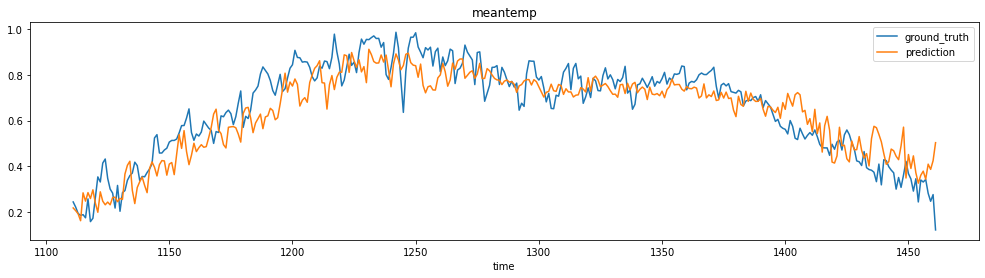

In [26]:
y_pred_sup = np.atleast_2d(model_xgb.predict(x_test_sup))

df_y_test = pd.DataFrame(format_y(y_test_sup.to_numpy()), columns=endog_names, index=y_test.index[n_steps_in:])
df_y_pred = pd.DataFrame(format_y(y_pred_sup), columns=endog_names, index=df_y_test.index)

plot_metrics(df_y_test.iloc[:,0], df_y_pred.iloc[:,0])

plot_pred(df_y_test, df_y_pred)

### Forecast mode 
Use auto-regression with pred values  
(only without exogeneous variable)

In [27]:
history = x_test_sup.iloc[[0],:].values[0]
y_pred_forecast = []
n_forecast = x_test_sup.shape[0]
for _ in range(n_forecast):
    forecast = model_xgb.predict(np.atleast_2d(history))
    history = np.roll(history, -1)
    history[-1] = np.atleast_2d(forecast)[0,0]
    y_pred_forecast.append(history[-1])
    
y_pred_forecast += list(forecast[0,1:])
y_pred_forecast = pd.DataFrame(y_pred_forecast, index=df_y_test.index)

In [28]:
# plot_metrics(df_y_test.squeeze(), y_pred_forecast.squeeze())

# plt.figure(figsize=(17,6))
# plt.plot(df_y_test)
# plt.plot(y_pred_forecast)
# plt.legend(['observed', 'forecast']);

## Integrate serie
From derivative to function

In [29]:
def do_undiff(y: np.array,
              y0: np.array) -> np.array:
    return np.cumsum(y, axis=0) + y0

def retrieve_data(y_true: pd.DataFrame,
                  y_pred: np.array,
                  undiff: list =[]) -> [pd.DataFrame, pd.DataFrame]:
    """ do unscaling and undiff data to get function from its derivative 
    ordre 1 : d_{t+1}=y_{t+1} - y_{t} \Leftrightarrow y_{t+k} = y_{t} + \sum_{i=1}^k d_{t+i}
    ordre 2 : d_{t+2}=y_{t+2} - 2y_{t+1} + y_{t} \Leftrightarrow y_{t+k} = ky_{t+1} - (k-1)y_{t}+ \sum_{i=2}^k (k-i+1)d_{t+i}
    """
    f_y_pred = format_y(y_pred)
    index = y_true.index.union(y_true.index-n_steps_out+1)
    df_true_unscaled = df[endog_names].loc[index]
    
    df_pred_unscaled = pd.DataFrame(scaler_endog.inverse_transform(np.atleast_2d(f_y_pred)), columns=endog_names, index=df_true_unscaled.index)
    if undiff:
        y0 = df[endog_names].loc[y_true.index[0]-n_steps_out].to_numpy()
        df_pred_unscaled[undiff] = do_undiff(df_pred_unscaled[undiff], y0[df_pred_unscaled.columns.get_loc(*undiff)])

    return df_true_unscaled, df_pred_unscaled

In [30]:
# plot_pred(*retrieve_data(y_test_sup, y_test_sup.to_numpy(), []))

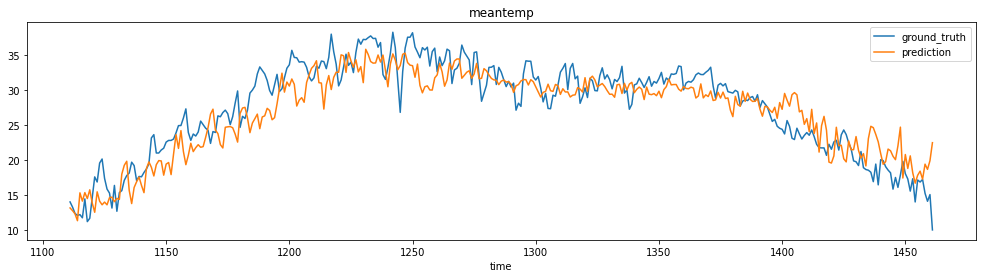

In [31]:
df_true_unscaled, df_pred_unscaled = retrieve_data(y_test_sup, y_pred_sup, [])
plot_pred(df_true_unscaled, df_pred_unscaled)

# Models comparison

/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


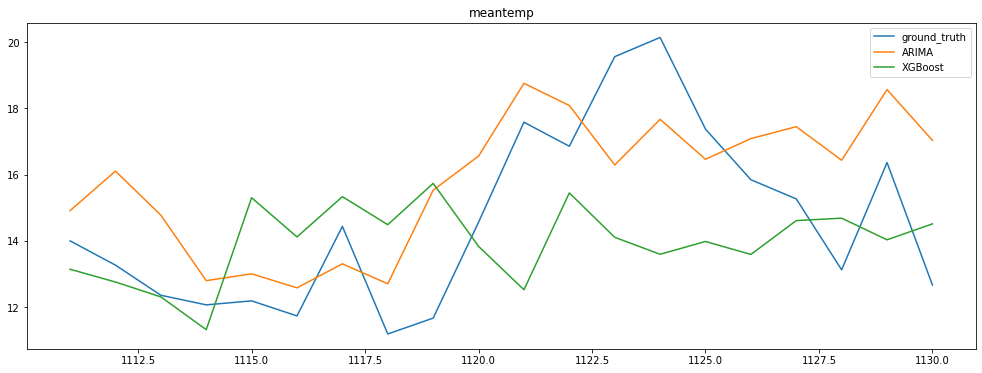

In [32]:
first_index = df_true_unscaled.index.min()
new_model_arima = model_arima.apply(endog=y_test_endog.loc[first_index-10: first_index], 
                                   exog=y_test_exog.loc[first_index-10: first_index]
                                   )
pred_forecast = new_model_arima.forecast(step,
                                        exog=y_test_exog.loc[first_index: first_index+step-1]
                                        )
pred_forecast.index = pred_forecast.index - pred_forecast.index.min() + df_pred_unscaled.index.min()

plt.figure(figsize=(17,6))
plt.plot(df_true_unscaled.iloc[:step])
plt.plot(pred_forecast)
plt.plot(df_pred_unscaled.iloc[:step])
plt.title(target)
plt.legend(["ground_truth", "ARIMA", "XGBoost"]);